In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [10]:
data = tf.keras.utils.image_dataset_from_directory('ocr-dataset/versions/1/dataset',image_size=(60,40),color_mode="grayscale")

Found 210227 files belonging to 62 classes.


In [11]:
data_iter = data.as_numpy_iterator()
data_iter

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001B28C0328C0>)

In [12]:
batch = data_iter.next()

In [13]:
print(len(batch),batch[1],batch[0].shape)
print(data.class_names)
class_names = data.class_names

2 [ 4 61 57 28 50  7 52 54  8 50 13 36 51 61 32 43 18 54 53 14  6 37  1 49
 46 35 32 25  1 32 28 21] (32, 60, 40, 1)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


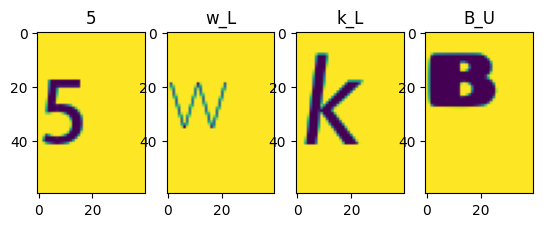

In [14]:
fig, ax = plt.subplots(1,4)
'''
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
'''

# Alternate way to view plots from tensorflow docs
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])
#print(img.shape)
#plt.imshow(img)

In [15]:
data = data.map(lambda x,y:(x/255,y))

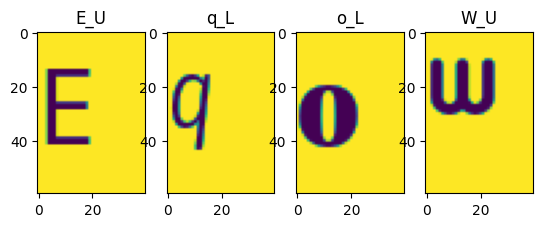

In [16]:
fig, ax = plt.subplots(1,4)
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [17]:
data_iter_val = data.as_numpy_iterator()

In [18]:
batch = data_iter_val.next()
print(batch[1])
batch[0].shape

[17 36  5 14  4 23 45 56 13 34 15 53 24 12 18 53 51 60 16 38 55 57 32 24
  2 52 52  4 10 30  8  2]


(32, 60, 40, 1)

In [19]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print(f"Training dataset size: {train_size}\nVal. dataset size: {val_size}\nTest dataset size: {test_size}\nTotal: {len(data)}")
print(f"Total size after splitting: {train_size+test_size+val_size}")
print(f"Was the split right: {train_size+test_size+val_size==len(data)}")

Training dataset size: 4599
Val. dataset size: 1314
Test dataset size: 657
Total: 6570
Total size after splitting: 6570
Was the split right: True


In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(60,40,1),padding="same"), # padding is applied
    # Each filter is of dimension 3,3,1 
  AveragePooling2D(pool_size=(2,2)), # The maximum value of 2x2 sub-matrix is taken
  
  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),
  
  Flatten(),
  Dense(62, activation='softmax') # changed to have 62 neurons (same as number of classes) and 'softmax' activation
])

C:\Users\Thiago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 30, 20, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 14, 9, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 6, 3, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 62)             │        35,774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,590 (213.24 KB)

 Trainable params: 54,590 (213.24 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Define a Callback class that stops training once accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [25]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse categorical entropy in case of softmax acti. func.
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [26]:
#Fit the model
history = model.fit(train,
                    epochs=10,
                    steps_per_epoch=len(train),
                    validation_data=val,
                    callbacks=[ModelCheckpoint("./models/checkpoints_new/{epoch:02d}.h5",save_best_only=True),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/10
4598/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6194 - loss: 1.6409

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 299s 65ms/step - accuracy: 0.6195 - loss: 1.6406 - val_accuracy: 0.8369 - val_loss: 0.6738
Epoch 2/10
4597/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8492 - loss: 0.6157

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 110s 24ms/step - accuracy: 0.8492 - loss: 0.6157 - val_accuracy: 0.8639 - val_loss: 0.5405
Epoch 3/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8732 - loss: 0.4964

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 114s 25ms/step - accuracy: 0.8732 - loss: 0.4963 - val_accuracy: 0.8734 - val_loss: 0.4881
Epoch 4/10
4597/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8864 - loss: 0.4351

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 120s 26ms/step - accuracy: 0.8864 - loss: 0.4351 - val_accuracy: 0.8804 - val_loss: 0.4517
Epoch 5/10
4598/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8937 - loss: 0.3963

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 108s 24ms/step - accuracy: 0.8937 - loss: 0.3963 - val_accuracy: 0.8877 - val_loss: 0.4238
Epoch 6/10
4597/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9013 - loss: 0.3694

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - accuracy: 0.9013 - loss: 0.3694 - val_accuracy: 0.8922 - val_loss: 0.4062
Epoch 7/10
4598/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9056 - loss: 0.3490

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - accuracy: 0.9056 - loss: 0.3490 - val_accuracy: 0.8939 - val_loss: 0.4046
Epoch 8/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9081 - loss: 0.3329

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.9081 - loss: 0.3329 - val_accuracy: 0.8951 - val_loss: 0.3954
Epoch 9/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - accuracy: 0.9116 - loss: 0.3194 - val_accuracy: 0.8945 - val_loss: 0.4000
Epoch 10/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9146 - loss: 0.3081

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 108s 24ms/step - accuracy: 0.9146 - loss: 0.3081 - val_accuracy: 0.8991 - val_loss: 0.3912


In [ ]:
#model.save("./models/ocr_model.h5")

In [34]:
epochs = [*range(1,11)]


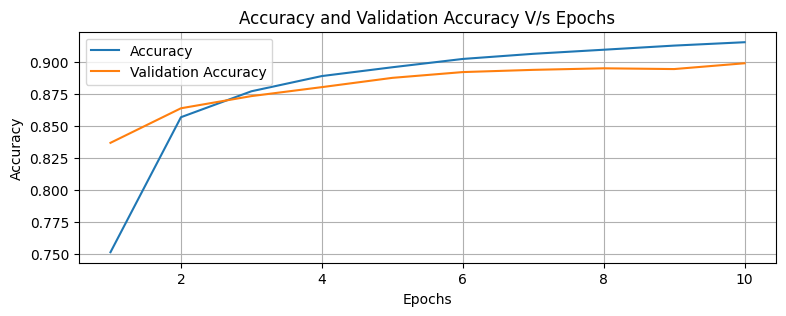

In [38]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["accuracy"])
ax.plot(epochs,history.history["val_accuracy"])
ax.legend(["Accuracy","Validation Accuracy"])
ax.set_title("Accuracy and Validation Accuracy V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.grid()
plt.savefig("models/model_perf/acc_plt.png",dpi=400)
plt.show(); plt.close()

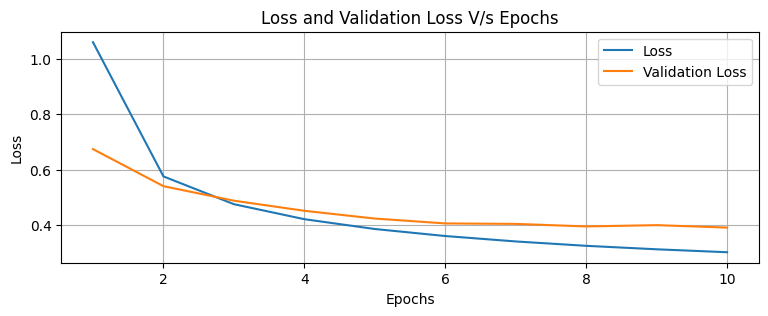

In [40]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["loss"])
ax.plot(epochs,history.history["val_loss"])
ax.legend(["Loss","Validation Loss"])
ax.set_title("Loss and Validation Loss V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.grid()
plt.savefig("./models/model_perf/loss_plt.png",dpi=400)
plt.show(); plt.close()

In [41]:
from tensorflow.keras.models import load_model

In [42]:
loaded_model = load_model("models/checkpoints_new/10.h5")

In [43]:
eval_data = loaded_model.evaluate(test)


657/657 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.9033 - loss: 0.3816


In [44]:
print(eval_data)

[0.3818233907222748, 0.9005758762359619]


In [45]:
predictions = np.array([])
labels = np.array([])

for x,y in test:
    predictions = np.concatenate([predictions,np.argmax(loaded_model.predict(x),axis=-1)])
    labels = np.concatenate([labels,y.numpy()])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━

In [46]:
print(predictions,labels)

[46.  1.  4. ... 47. 61. 26.] [46.  1.  4. ... 47. 61. 26.]


In [49]:
import seaborn as sns

In [48]:
conf_mat = tf.math.confusion_matrix(labels,predictions)

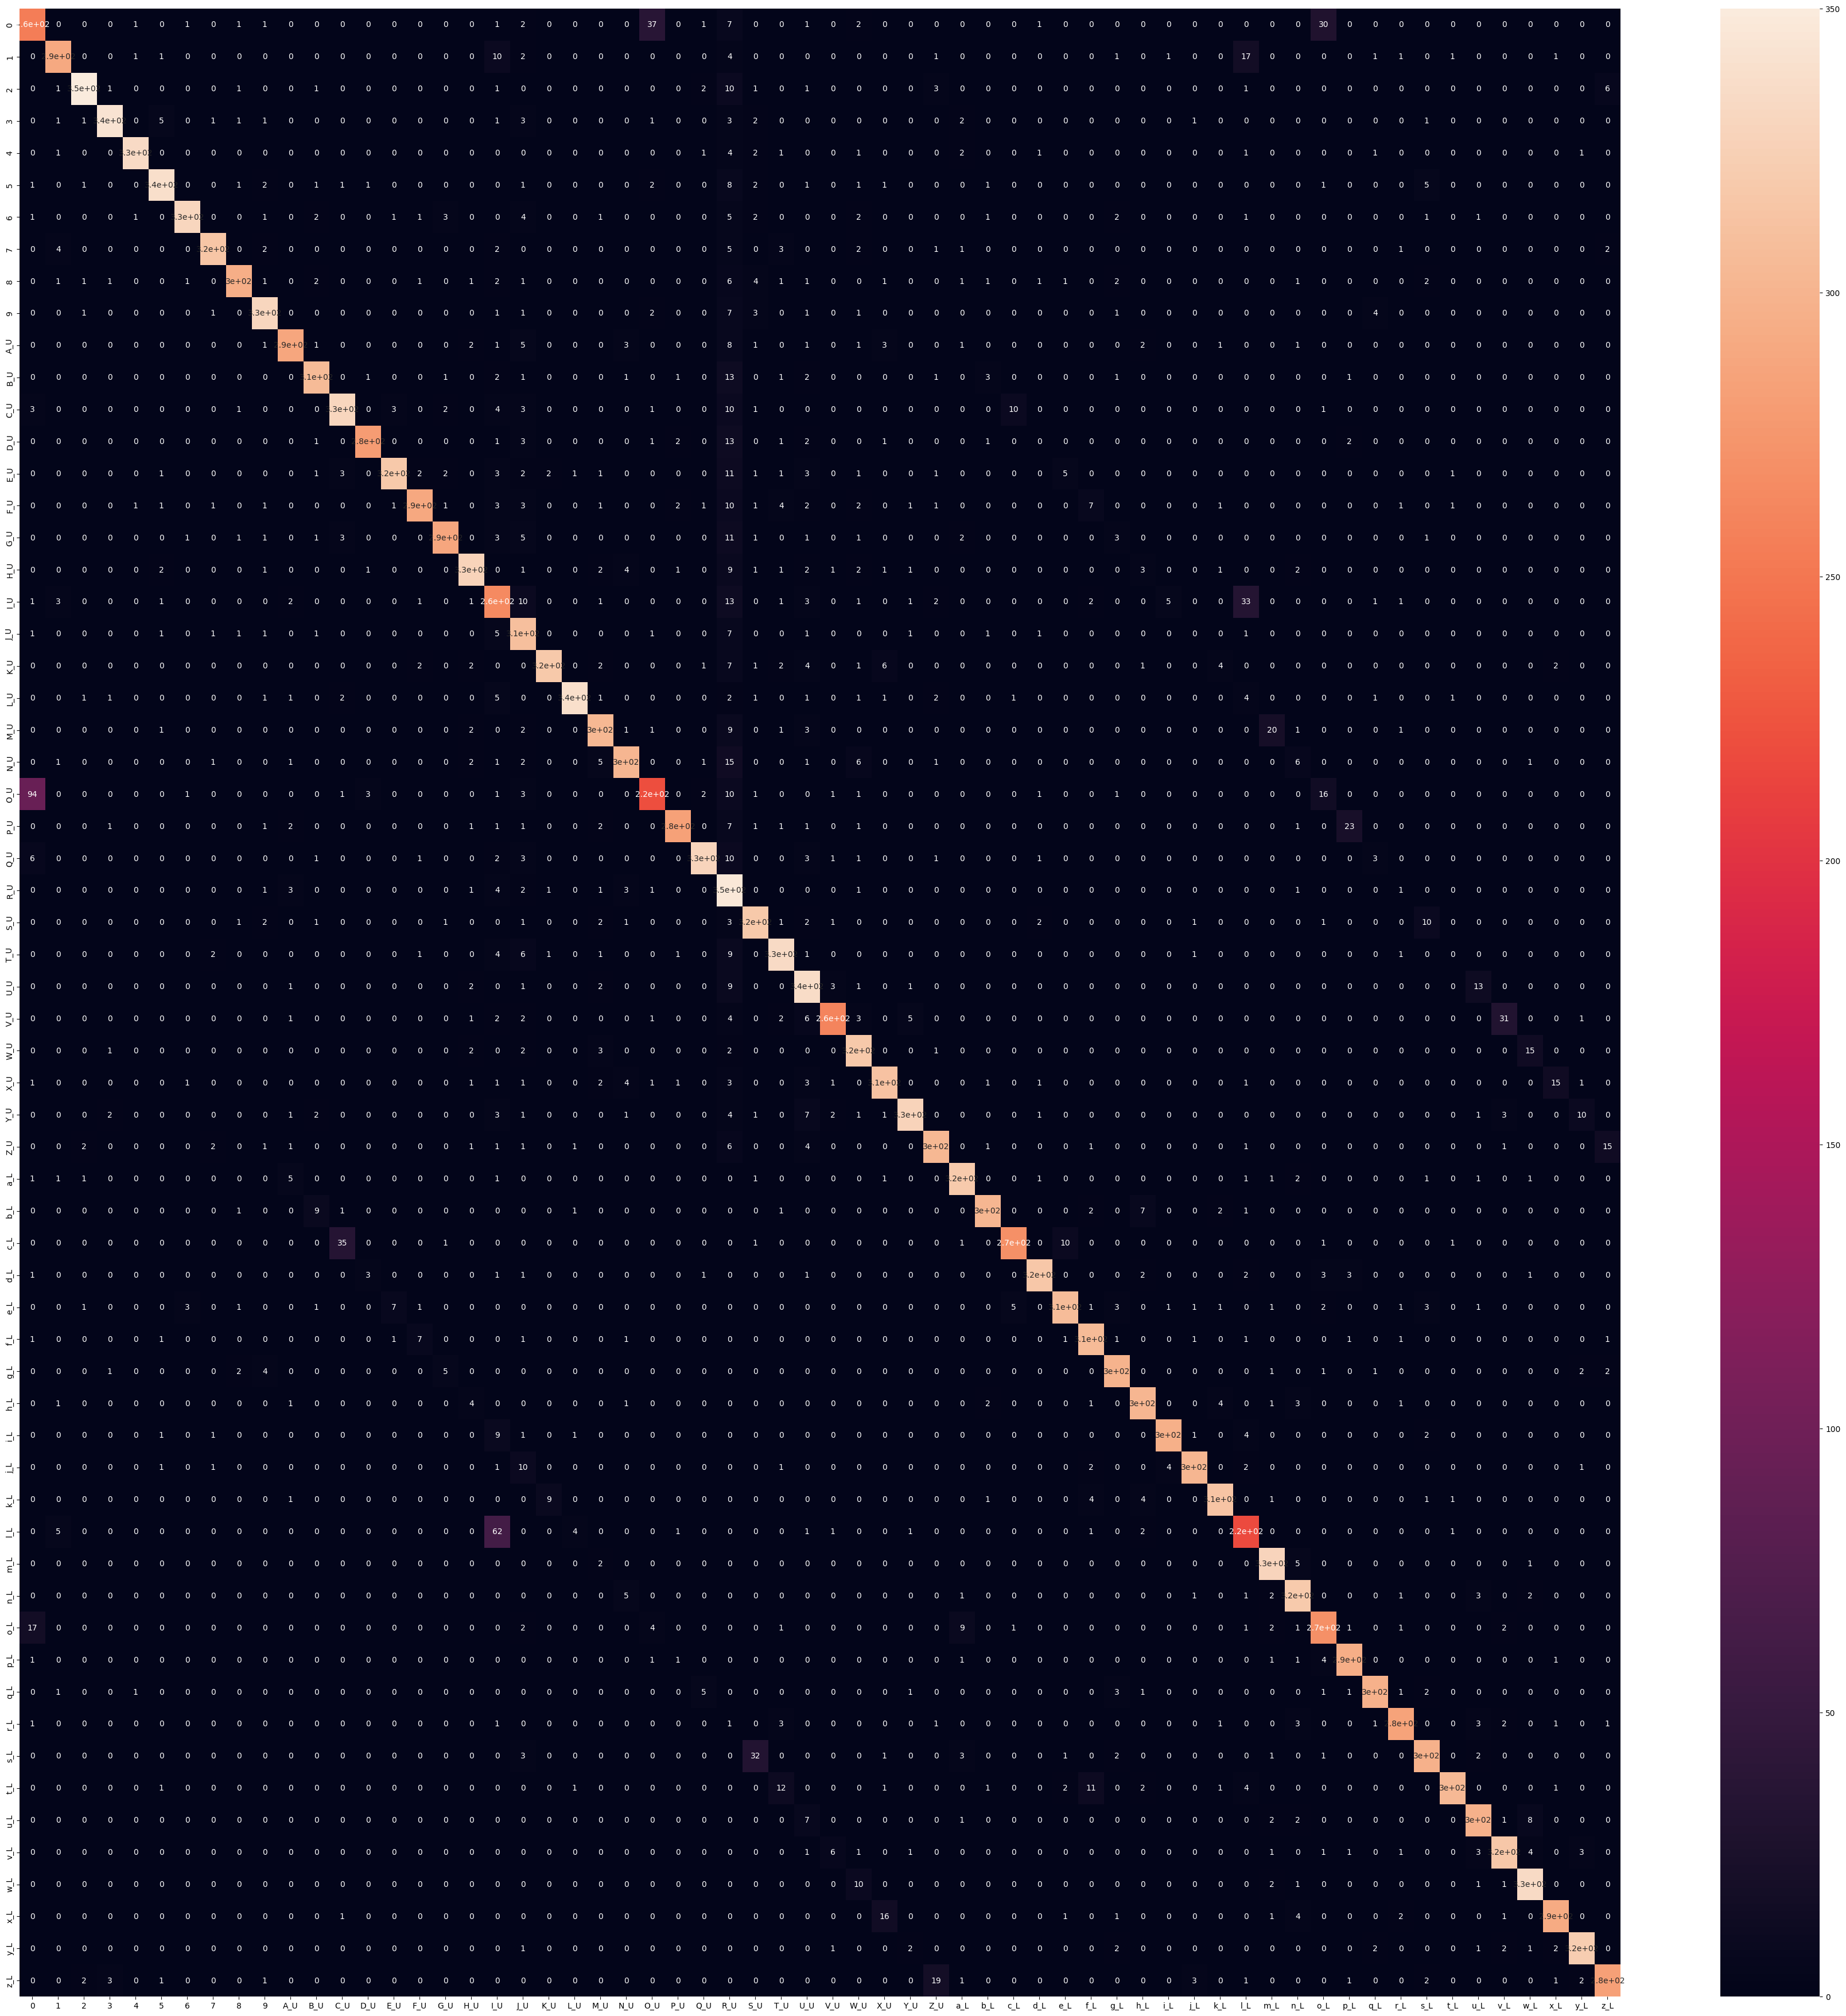

In [50]:
fig, ax = plt.subplots(figsize=(45,45))
sns.heatmap(conf_mat,ax=ax,annot=True)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.savefig("models/conf_matrix_new.png",dpi=400)

In [51]:
import random

In [54]:
def load_random():
    ranges = [*range(0,1000,1)]
    values = random.choices(ranges,k=62)
    images = list()
    for i in range(len(values)):
        if i<10:
            
            img = cv2.imread(f"ocr-dataset/versions/1/dataset/{i}/{values[i]}.png")
        else:
            img = cv2.imread(f"ocr-dataset/versions/1/dataset/{class_names[i]}/{class_names[i]}_{values[i]}.png")
        if img is not None:
            images.append(img)
        else:
            if i<10:
                img = cv2.imread(f"ocr-dataset/versions/1/dataset/{i}/1.png")
            else:
                img = cv2.imread(f"ocr-dataset/versions/1/dataset/{class_names[i]}/{class_names[i]}_1.png")

    return images
        
    
def plot_those_imgs(images,**kwargs):
    fig, ax = plt.subplots(8,8,figsize=(16,16))
    fig.tight_layout()
    for i in range(len(images)):
        ax[i//8,i%8].imshow(images[i])
        if len(kwargs)==0:
            ax[i//8,i%8].title.set_text(f"{class_names[i]}")
        else:
            ax[i//8,i%8].title.set_text(f"{class_names[i]} - {kwargs['acc'][i]}")
    plt.show()

61


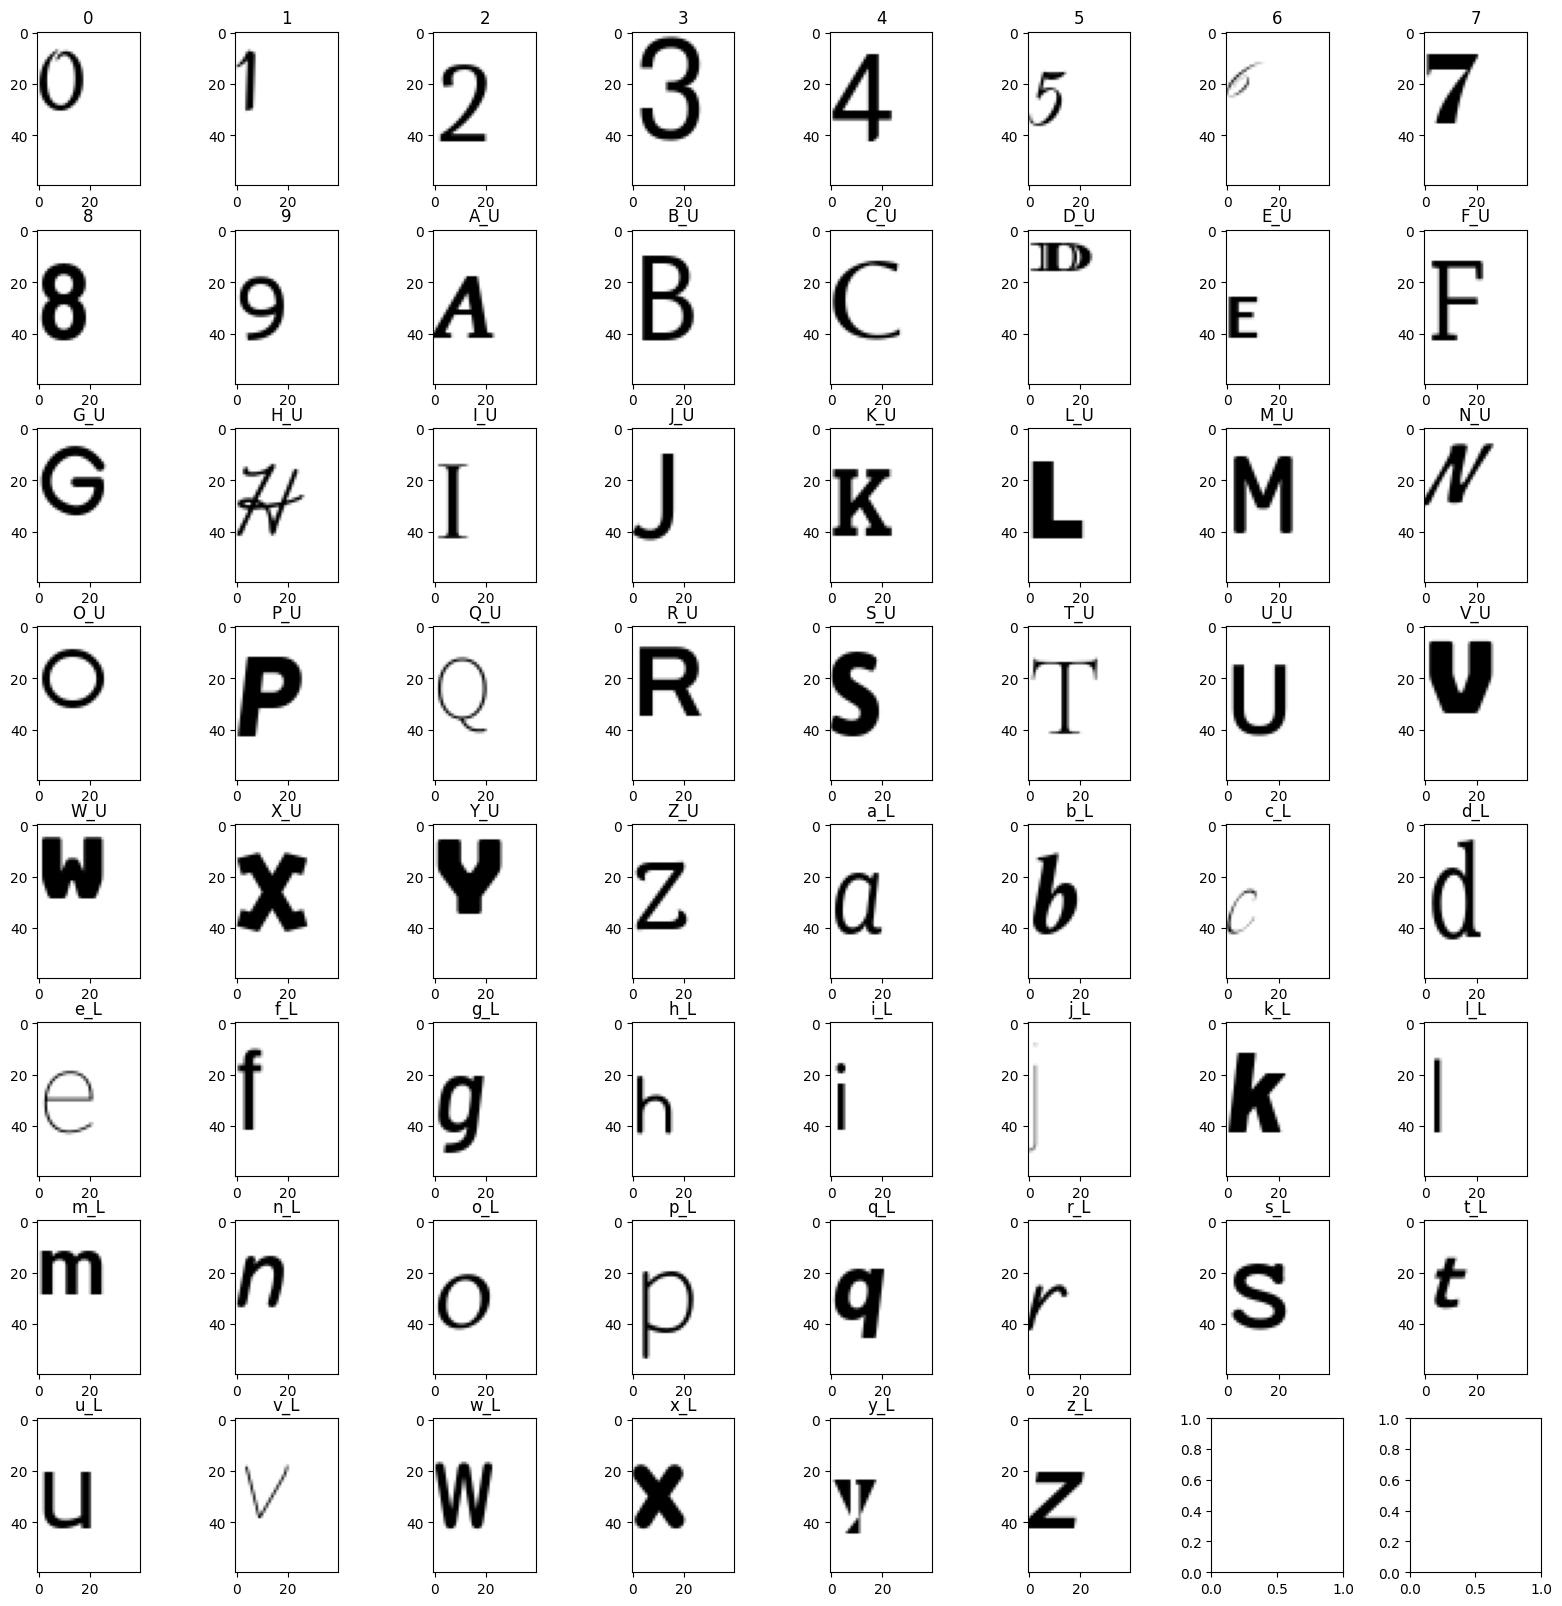

In [55]:
while True:
    images = load_random()
    if len(images)==62:
        break
    print(len(images))

plot_those_imgs(images)

plt.close()

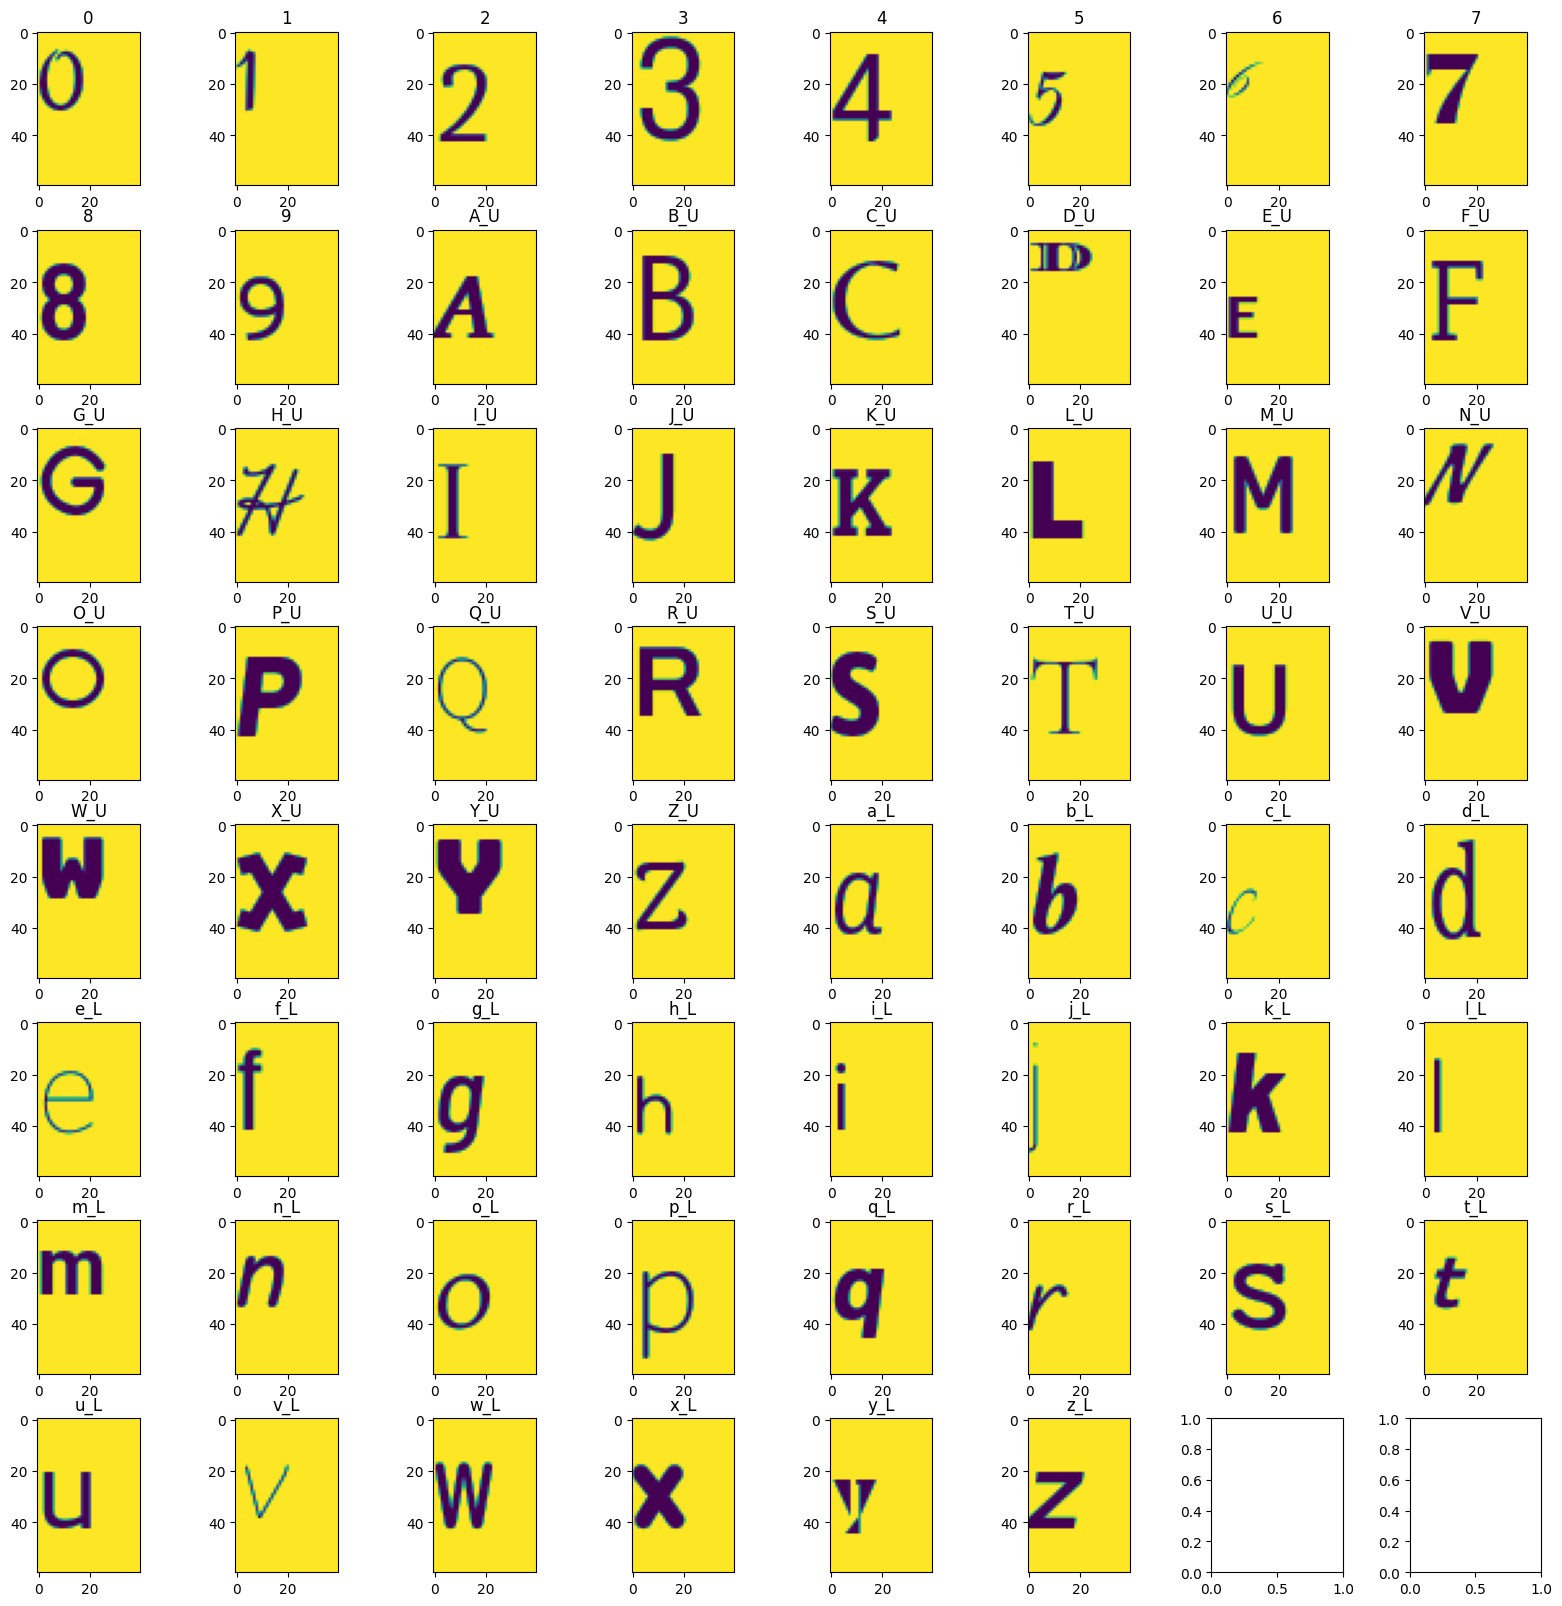

In [56]:
resize = tf.image.resize(tf.image.rgb_to_grayscale(images),(60,40))
plot_those_imgs(resize)

In [57]:
yhat = loaded_model.predict(*np.expand_dims(resize/255, 0))
yhat

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[7.6562256e-01, 2.1127418e-08, 9.8178571e-05, ..., 9.6488968e-08,
        2.0658985e-07, 6.8564878e-14],
       [1.5823124e-03, 9.3298376e-01, 9.1287038e-06, ..., 1.1099015e-05,
        1.8059654e-05, 1.0797382e-07],
       [1.7733494e-12, 4.6149364e-09, 9.9999821e-01, ..., 7.3055499e-15,
        9.5796525e-16, 1.4490153e-11],
       ...,
       [2.6921079e-16, 1.2465642e-12, 3.0553450e-16, ..., 9.9618405e-01,
        1.1515522e-07, 9.3221568e-12],
       [7.4876773e-08, 7.4021904e-09, 2.4007542e-11, ..., 4.2527940e-06,
        9.9563688e-01, 1.6994443e-07],
       [3.9389763e-12, 2.5313274e-09, 2.6261861e-05, ..., 2.1771529e-08,
        7.0190923e-12, 9.9892396e-01]], dtype=float32)

['0.77 - 0', '0.93 - 1', '1.0 - 2', '1.0 - 3', '1.0 - 4', '1.0 - 5', '0.31 - a_L', '1.0 - 7', '1.0 - 8', '1.0 - 9', '0.98 - A_U', '1.0 - B_U', '1.0 - C_U', '0.35 - D_U', '0.96 - E_U', '0.97 - F_U', '1.0 - G_U', '0.96 - H_U', '0.98 - I_U', '1.0 - J_U', '1.0 - K_U', '1.0 - L_U', '1.0 - M_U', '0.79 - N_U', '0.98 - O_U', '1.0 - P_U', '0.99 - Q_U', '1.0 - R_U', '1.0 - S_U', '1.0 - T_U', '1.0 - U_U', '0.57 - U_U', '1.0 - W_U', '1.0 - X_U', '0.51 - V_U', '0.91 - Z_U', '1.0 - a_L', '1.0 - b_L', '0.63 - c_L', '1.0 - d_L', '0.99 - e_L', '0.98 - f_L', '1.0 - g_L', '0.72 - h_L', '0.99 - i_L', '0.56 - j_L', '1.0 - k_L', '0.78 - I_U', '1.0 - m_L', '1.0 - n_L', '0.67 - o_L', '1.0 - p_L', '1.0 - q_L', '0.86 - r_L', '0.78 - S_U', '0.99 - t_L', '1.0 - u_L', '1.0 - v_L', '0.98 - w_L', '1.0 - x_L', '1.0 - y_L', '1.0 - z_L']


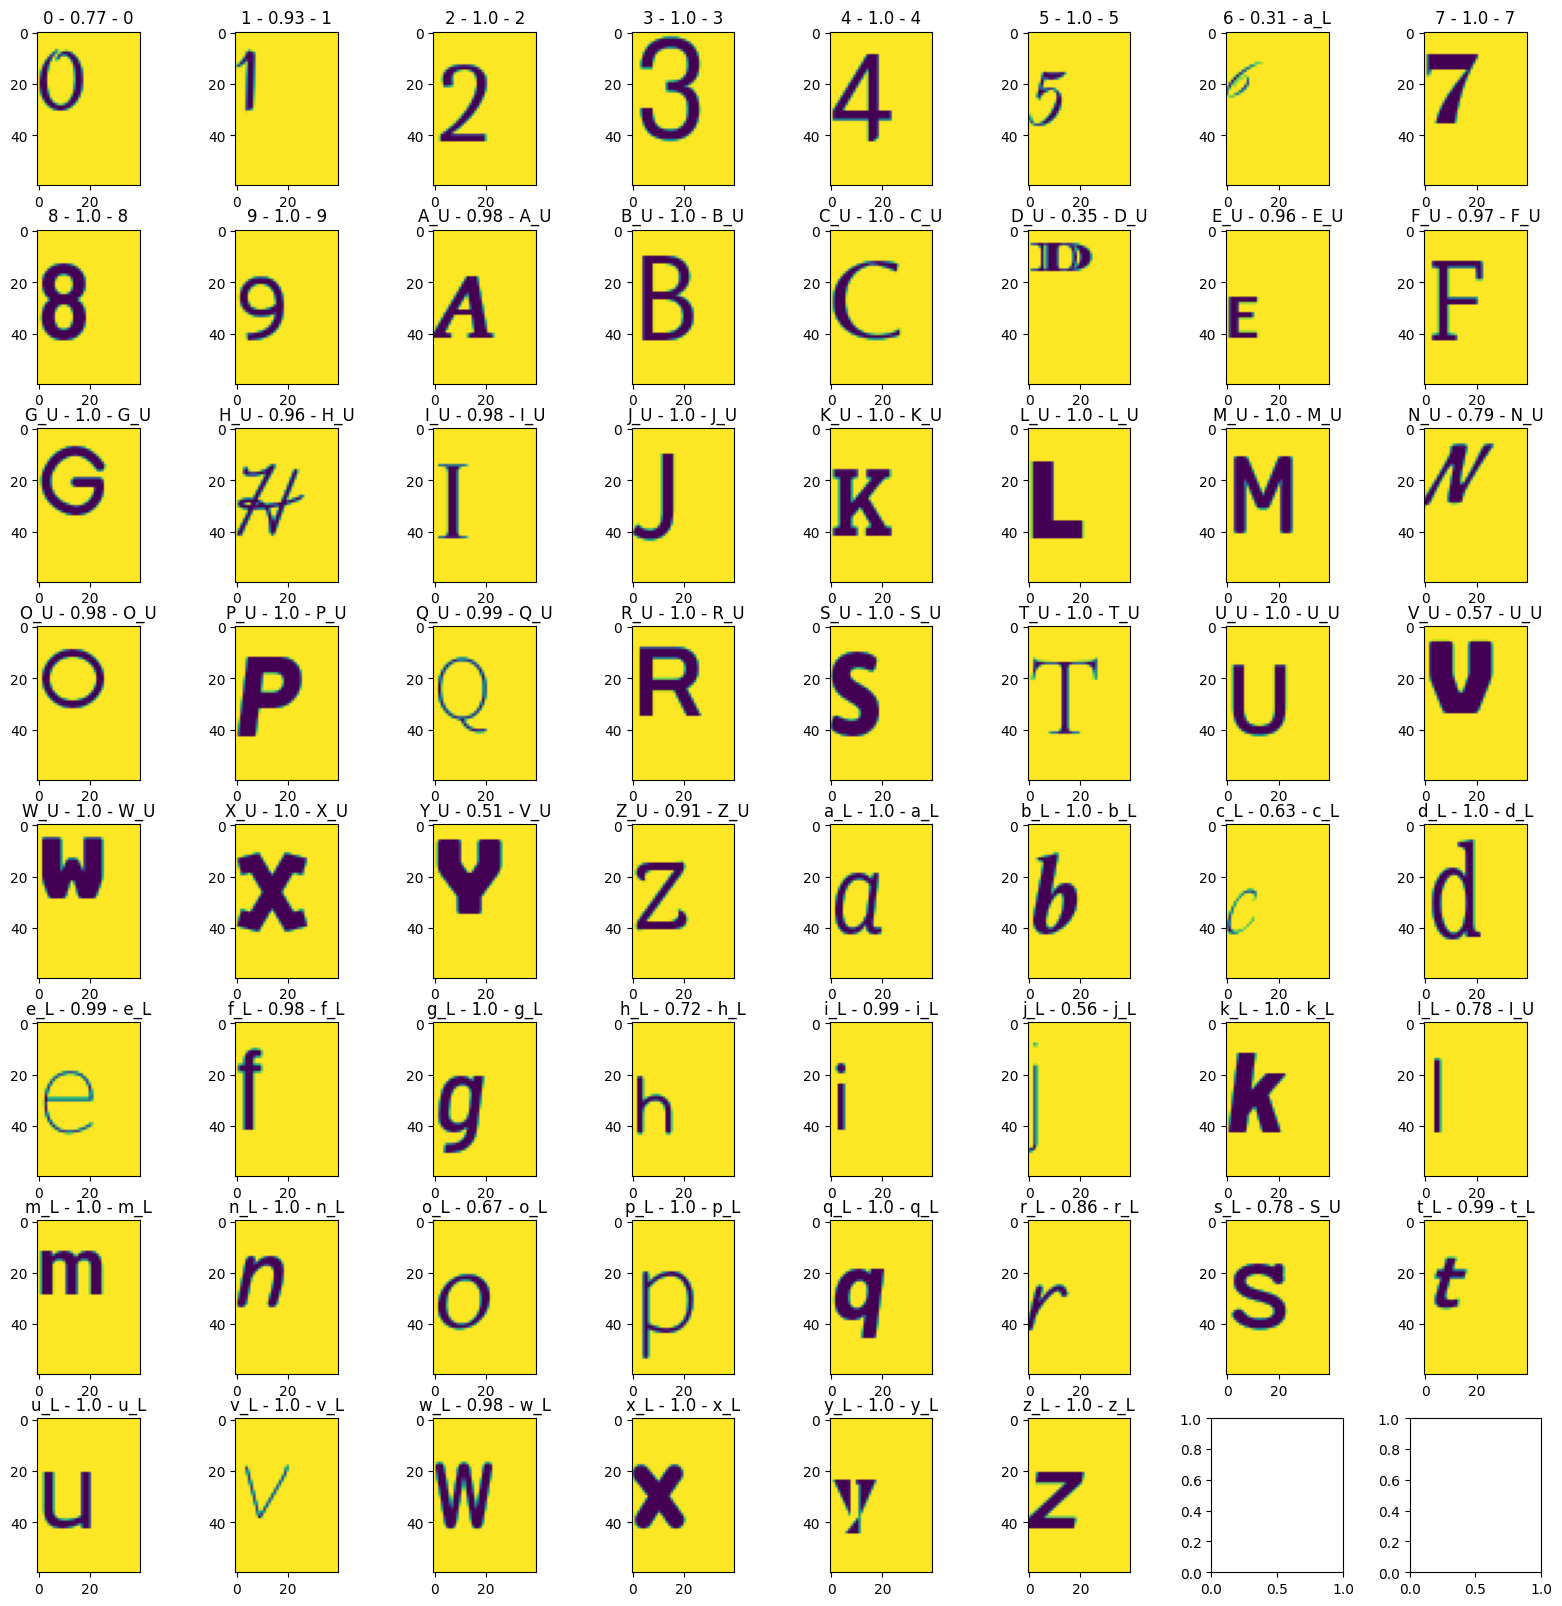

In [58]:
acc_pred = [f"{round(float(yhat[i][np.argmax(yhat[i])]),2)} - {class_names[np.argmax(yhat[i])]}" for i in range(len(yhat))]
print(acc_pred)
plot_those_imgs(resize,acc=acc_pred)